<h1>SuperBand using ATR (average true range)</h1>

In [1]:
# https://www.investopedia.com/terms/a/atr.asp
import warnings
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

df = web.DataReader("FDS", data_source='yahoo', start='01-01-2020')

In [2]:
def atr(df, moving_average_days=5):
  ''' True range = max('h-l', abs(high-previous_close), abs(low-previous_close) )
  ATR is its moving average'''
  df['previous_close'] = df['Close'].shift(1)
  df['h-l'] = df['High'] - df['Low']
  df['h-previous_close'] = abs(df['High'] - df['previous_close'])
  df['l-previous_close'] = abs(df['Low'] - df['previous_close'])

  tr = df[['h-l','h-previous_close','l-previous_close']].max(axis=1)
  atr = tr.rolling(moving_average_days).mean()
  df.drop(['h-l', 'h-previous_close', 'l-previous_close'], axis=1, inplace=True )

  return atr

In [3]:
# generate superbands from averge true range
def superband(df, multipler=3):
    average_super_trend = atr(df, 15)
    # ATR basic upper band = (high + low) /2 + (multiplier *atr)
    df['TR_upper_band'] = (df['High'] + df['Low'])/2 + multipler*average_super_trend
    # ATR basic lower band = (high + low) /2 - (multiplier *atr)
    df['TR_lower_band'] = (df['High'] + df['Low'])/2 - multipler*average_super_trend
    return df

In [4]:
df_superband = superband(df, 1.5)
df_superband

,High,Low,Open,Close,Volume,Adj Close,previous_close,TR_upper_band,TR_lower_band
Date,,,,,,,,,
2020-01-02,270.179993,266.600006,268.660004,268.730011,314500.0,265.476196,NaN,NaN,NaN
2020-01-03,269.380005,264.869995,265.920013,268.670013,237400.0,265.416931,268.730011,NaN,NaN
2020-01-06,267.299988,263.750000,266.859985,267.160004,349900.0,263.925171,268.670013,NaN,NaN
2020-01-07,270.350006,266.190002,267.000000,267.029999,235200.0,263.796783,267.160004,NaN,NaN
2020-01-08,270.380005,267.049988,267.140015,269.089996,288600.0,265.831848,267.029999,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-18,326.940002,321.390015,326.329987,321.720001,96700.0,321.720001,326.529999,335.458011,312.872006
2021-05-19,322.489990,317.549988,317.970001,322.399994,131900.0,322.399994,321.720001,331.050992,308.988986
2021-05-20,330.540009,322.829987,322.829987,327.309998,172300.0,327.309998,322.399994,337.804001,315.565994


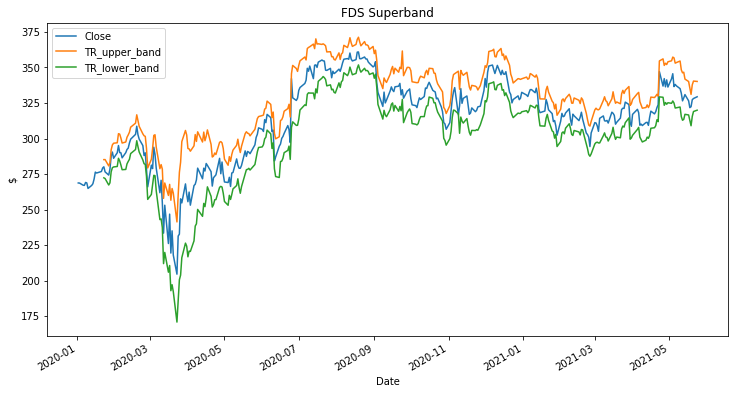

In [5]:
column_list = ['Close', 'TR_upper_band', 'TR_lower_band']
df_superband[column_list].plot(figsize=(12.2, 6.4))
plt.title('FDS Superband')
plt.ylabel('$')
plt.show()

<h1>Compare with Bollinger Bands</h1>

$ typical \; price = \frac{High + Low + Close}{3} $

In [6]:
typical_price = (df['High'] + df['Low'] + df['Close'])/3
sma_period = 5
# similar to superband's ATR, Bollinger Bands use SMA Standard deviation
df['Tp_SMA'] = typical_price.rolling(window=sma_period).mean()
df['2xTPSTD'] = typical_price.rolling(window=sma_period).std() * 2
df['BB_Upper']= df['Tp_SMA'] + df['2xTPSTD'] 
df['BB_Lower']= df['Tp_SMA'] - df['2xTPSTD']
df.drop(['Tp_SMA','2xTPSTD'], axis=1, inplace=True)
df

,High,Low,Open,Close,Volume,Adj Close,previous_close,TR_upper_band,TR_lower_band,BB_Upper,BB_Lower
Date,,,,,,,,,,,
2020-01-02,270.179993,266.600006,268.660004,268.730011,314500.0,265.476196,NaN,NaN,NaN,NaN,NaN
2020-01-03,269.380005,264.869995,265.920013,268.670013,237400.0,265.416931,268.730011,NaN,NaN,NaN,NaN
2020-01-06,267.299988,263.750000,266.859985,267.160004,349900.0,263.925171,268.670013,NaN,NaN,NaN,NaN
2020-01-07,270.350006,266.190002,267.000000,267.029999,235200.0,263.796783,267.160004,NaN,NaN,NaN,NaN
2020-01-08,270.380005,267.049988,267.140015,269.089996,288600.0,265.831848,267.029999,NaN,NaN,269.925916,265.638085
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,326.940002,321.390015,326.329987,321.720001,96700.0,321.720001,326.529999,335.458011,312.872006,333.105723,322.535614
2021-05-19,322.489990,317.549988,317.970001,322.399994,131900.0,322.399994,321.720001,331.050992,308.988986,334.312913,318.239085
2021-05-20,330.540009,322.829987,322.829987,327.309998,172300.0,327.309998,322.399994,337.804001,315.565994,333.013947,318.475384


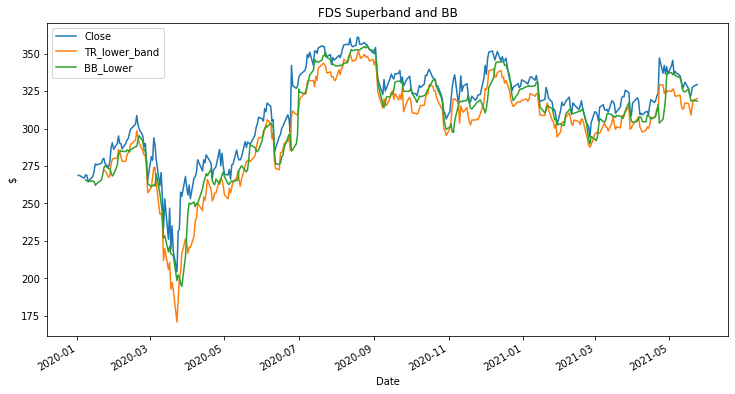

In [7]:
# column_list = ['Close', 'TR_upper_band', 'TR_lower_band', 'BB_Upper', 'BB_Lower']
column_list = ['Close', 'TR_lower_band',  'BB_Lower']
df[column_list].plot(figsize=(12.2, 6.4))
plt.title('FDS Superband and BB')
plt.ylabel('$')
plt.show()

use candle stick instead of closing price to have a better picture

In [8]:
import plotly.graph_objects as go
trace1 = {
    'x': df.index,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': 'FDS',
    'yaxis': 'y2',
    'showlegend': True
}

trace2 = {
    'x': df.index,
    'y': df.TR_lower_band,
    'yaxis': 'y2',
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'purple'
            },
    'name': 'SuperTrend Lower Band'
}

trace3 = {
    'x': df.index,
    'y': df.BB_Lower,
    'yaxis': 'y2',
    'type': 'scatter',
    'mode': 'lines',
    'line': {
        'width': 1,
        'color': 'red'
            },
    'name': 'Bollinger band Lower Band'
}

colors = []
INCREASING_COLOR = '#17BECF'
DECREASING_COLOR = '#7F7F7F'

for i in range(len(df.Close)):
    if i != 0:
        if df.Close[i] > df.Close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)

trace4 = {
    'x': df.index,
    'y': df.Volume,
    'marker': dict( color=colors ),
    'type': 'bar', 
    'yaxis': 'y', 
    'name': 'Volume'
}

In [9]:
data = [trace1, trace2, trace3, trace4]
layout = go.Layout({
    'title': {
        'text': 'compare SuperTrend and BB lower bands ',
        'font': {
            'size': 12
        }
    },
    "yaxis": {"domain": [0, 0.2]},
    "yaxis2": {"domain": [0.2, 0.8]}
})

In [10]:
fig = go.Figure(data=data, layout=layout)
fig.show()

In [11]:
df.query('High > TR_upper_band')

,High,Low,Open,Close,Volume,Adj Close,previous_close,TR_upper_band,TR_lower_band,BB_Upper,BB_Lower
Date,,,,,,,,,,,
2020-11-09,348.480011,316.320007,345.869995,316.709991,333000.0,315.144867,335.829987,347.400012,317.400006,340.421622,315.291716
2021-04-23,365.769989,318.149994,323.730011,347.100006,1450500.0,347.100006,323.790009,354.605991,329.313992,346.172387,303.691610


In [12]:
df.query('Low < TR_lower_band')

,High,Low,Open,Close,Volume,Adj Close,previous_close,TR_upper_band,TR_lower_band,BB_Upper,BB_Lower
Date,,,,,,,,,,,
2020-11-09,348.480011,316.320007,345.869995,316.709991,333000.0,315.144867,335.829987,347.400012,317.400006,340.421622,315.291716
2021-04-23,365.769989,318.149994,323.730011,347.100006,1450500.0,347.100006,323.790009,354.605991,329.313992,346.172387,303.691610


In [13]:
df.query('previous_close > TR_upper_band')

,High,Low,Open,Close,Volume,Adj Close,previous_close,TR_upper_band,TR_lower_band,BB_Upper,BB_Lower
Date,,,,,,,,,,,
2020-03-09,272.179993,249.539993,257.500000,261.859985,712200.0,259.333374,279.079987,278.775986,242.944000,302.569273,256.640059
2020-06-09,309.559998,298.179993,309.559998,304.899994,471600.0,302.733185,314.730011,314.719986,293.020004,320.566316,302.259014
2020-06-11,298.959991,283.559998,298.529999,284.200012,349500.0,282.180328,305.890015,303.761990,278.757999,327.812385,284.476946
2021-03-30,318.799988,304.070007,314.489990,311.339996,408800.0,311.339996,323.950012,323.341998,299.527997,330.962860,309.691807


In [14]:
df.query('previous_close < TR_lower_band')

,High,Low,Open,Close,Volume,Adj Close,previous_close,TR_upper_band,TR_lower_band,BB_Upper,BB_Lower
Date,,,,,,,,,,,
2020-06-25,343.779999,309.649994,319.230011,342.160004,893600.0,339.728424,297.209991,345.609998,307.819995,335.429051,284.96828
2021-04-23,365.769989,318.149994,323.730011,347.100006,1450500.0,347.100006,323.790009,354.605991,329.313992,346.172387,303.69161


In [31]:
df['uptrend'] = True
for i in range(1, len(df)):
  if df['Close'].iloc[i] > df['TR_upper_band'].iloc[i-1]:
    # print(df.index[i], df['Close'].iloc[i], df['TR_upper_band'].iloc[i-1])
    df['uptrend'].iloc[i] = True
  elif df['Close'].iloc[i] < df['TR_lower_band'].iloc[i-1]:
    df['uptrend'].iloc[i] = False
  else:
    df['uptrend'].iloc[i] = df['uptrend'].iloc[i-1]

    if df['uptrend'].iloc[i] and df['TR_lower_band'].iloc[i] < df['TR_lower_band'].iloc[i-1]: # in uptrend, compare lowerband and flatten the lowerband curve
       df['TR_lower_band'].iloc[i] = df['TR_lower_band'].iloc[i-1]

    if not df['uptrend'].iloc[i] and df['TR_upper_band'].iloc[i] > df['TR_upper_band'].iloc[i-1]:
       df['TR_upper_band'].iloc[i] = df['TR_upper_band'].iloc[i-1]

df


,High,Low,Open,Close,Volume,Adj Close,previous_close,TR_upper_band,TR_lower_band,BB_Upper,BB_Lower,uptrend
Date,,,,,,,,,,,,
2020-01-02,270.179993,266.600006,268.660004,268.730011,314500.0,265.476196,NaN,NaN,NaN,NaN,NaN,True
2020-01-03,269.380005,264.869995,265.920013,268.670013,237400.0,265.416931,268.730011,NaN,NaN,NaN,NaN,True
2020-01-06,267.299988,263.750000,266.859985,267.160004,349900.0,263.925171,268.670013,NaN,NaN,NaN,NaN,True
2020-01-07,270.350006,266.190002,267.000000,267.029999,235200.0,263.796783,267.160004,NaN,NaN,NaN,NaN,True
2020-01-08,270.380005,267.049988,267.140015,269.089996,288600.0,265.831848,267.029999,NaN,NaN,269.925916,265.638085,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-18,326.940002,321.390015,326.329987,321.720001,96700.0,321.720001,326.529999,335.458011,312.872006,333.105723,322.535614,False
2021-05-19,322.489990,317.549988,317.970001,322.399994,131900.0,322.399994,321.720001,331.050992,308.988986,334.312913,318.239085,False
2021-05-20,330.540009,322.829987,322.829987,327.309998,172300.0,327.309998,322.399994,331.050992,315.565994,333.013947,318.475384,False


In [16]:
df.shape

(351, 11)